In [2952]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('text',usetex=False)

from pathlib import Path
import os,sys
import h5py, json
import sys 
import pickle as pkl
import time

import nept
sys.path.append('../PreProcessing/')  
sys.path.append('../TrackingAnalyses/')  
sys.path.append('../Lib/')
sys.path.append('../Analyses/')
from filters_ag import *

from importlib import reload  # Python 3.4+ only.
import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import stats_functions as StatsF
import plot_functions as PF
import zone_analyses_session as ZA


In [3]:
animal = 'Li'
task = 'T3g'
date = '062718'
session = animal+'_'+task+'_'+date

In [5]:
sessionPaths = ZA.getSessionPaths(oakPaths,session)
PosDat = TMF.getBehTrackData(sessionPaths,0)
cell_FR, mua_FR = SF.getSessionFR(sessionPaths)


Loading Beh Tracking Data
Complete.
Loading Spikes...
Binned Spike Files Loaded.
Loading FRs ...
FR Loaded.


In [2759]:
import numpy as np
from scipy.sparse.linalg import svds
from functools import partial


def emsvd(Y, k=None, tol=1E-3, maxiter=None):
    """
    Approximate SVD on data with missing values via expectation-maximization

    Inputs:
    -----------
    Y:          (nobs, ndim) data matrix, missing values denoted by NaN/Inf
    k:          number of singular values/vectors to find (default: k=ndim)
    tol:        convergence tolerance on change in trace norm
    maxiter:    maximum number of EM steps to perform (default: no limit)

    Returns:
    -----------
    Y_hat:      (nobs, ndim) reconstructed data matrix
    mu_hat:     (ndim,) estimated column means for reconstructed data
    U, s, Vt:   singular values and vectors (see np.linalg.svd and 
                scipy.sparse.linalg.svds for details)
    """

    if k is None:
        svdmethod = partial(np.linalg.svd, full_matrices=False)
    else:
        svdmethod = partial(svds, k=k)
    if maxiter is None:
        maxiter = np.inf

    # initialize the missing values to their respective column means
    mu_hat = np.nanmean(Y, axis=0, keepdims=1)
    valid = np.isfinite(Y)
    Y_hat = np.where(valid, Y, mu_hat)

    halt = False
    ii = 1
    v_prev = 0

    while not halt:

        # SVD on filled-in data
        U, s, Vt = svdmethod(Y_hat - mu_hat)

        # impute missing values
        Y_hat[~valid] = (U.dot(np.diag(s)).dot(Vt) + mu_hat)[~valid]

        # update bias parameter
        mu_hat = Y_hat.mean(axis=0, keepdims=1)

        # test convergence using relative change in trace norm
        v = s.sum()
        if ii >= maxiter or ((v - v_prev) / v_prev) < tol:
            halt = True
        ii += 1
        v_prev = v

    return Y_hat, mu_hat, U, s, Vt

In [1990]:
def getPosSequence(PosZones,startID,endID):
    nSamps = len(PosZones)
    pos = []
    samp = []
    
    pos.append(PosZones[0])
    samp.append(0)
    for p in np.arange(nSamps-1):
        p0 = PosZones[p]
        p1 = PosZones[p+1]
        if p0!=p1:
            pos.append(p1)
            samp.append(p+1)
    pos = np.array(pos)
    samp = np.array(samp) + startID
    nPos = len(pos)
    dur = np.zeros(nPos,dtype=int)
    for p in np.arange(nPos-1):
        dur[p] = samp[p+1]-samp[p]
    dur[-1] = endID-samp[-1]
        
    return pos, samp, dur

def cmp(a,b):
    return (a>b)-(a<b)

def getTrials(dat,**kwargs):
    nTr = dat.shape[0]
    trials = set(np.arange(1,nTr+1))
    try:
        for k,v in kwargs.items():
            trials = trials & set(np.where(dat[k]==v)[0]+1)
    except:
        print('Invalid Selection {} {}'.format(k,v))
        pass
    return np.sort(np.array(list(trials)))

def zscore(x,mu,sig):
    return (x-mu)/sig

def getFR_TrZone(TrialInfo, FRMat):
    nCells = FRMat.shape[0]
    TrZnFR = {} # FR for every zone visited in that trial
    OTrZnFR = {} # FR for every zone visited in that trial
    
    for tr in TrialInfo['All']['Trials']:
        nPos = len(TrialInfo['TrSeq']['Pos'][tr])
        trSpPos = np.zeros((nCells,nPos))
        for p in np.arange(nPos):
            s=TrialInfo['TrSeq']['Samp'][tr][p]
            d=TrialInfo['TrSeq']['Dur'][tr][p] 
            samps = np.arange(s,s+d)
            for cell in np.arange(nCells):
                trSpPos[cell, p]=np.mean(FRMat[cell][samps])
        
        nPos = len(TrialInfo['OffTrSeq']['Pos'][tr])
        otrSpPos = np.zeros((nCells,nPos))
        for p in np.arange(nPos):
            s=TrialInfo['OffTrSeq']['Samp'][tr][p]
            d=TrialInfo['OffTrSeq']['Dur'][tr][p] 
            samps = np.arange(s,s+d)
            for cell in np.arange(nCells):
                otrSpPos[cell, p]=np.mean(FRMat[cell][samps])
        
        TrZnFR[tr] = trSpPos
        OTrZnFR[tr] = otrSpPos
    return TrZnFR, OTrZnFR
def AICc(model):
    n = model.nobs
    llf = model.llf
    k = len(model.params)
    AIC = 2*(k-llf)
    c = 2*k*(k+1)/(n-k-1)
    return AIC+c

def R2(x,y):
    return (np.corrcoef(x,y)**2)[0,1]

def aR2(model,y,fit=[]):
    if fit==[]:
        fit = model.fittedvalues
    r2 = R2(fit,y)
    n = model.nobs
    p = len(model.params)-1
    aR2 = 1-(1-r2)*(n-1)/(n-p-1)
    return aR2

def getParamSet():
    '''
    Returns a dictionary of parameter sets for modeling.
    '''
    params = ['Loc','IO','Cue','Desc','Co']
    combs = []

    for i in np.arange(1, len(params)+1):
        combs+= [list(x) for x in combinations(params, i)]
    param_set = {}
    cnt=0
    for c in combs:
        param_set[cnt] = c
        cnt+=1

    for c in combs:
        if ('IO' in c) and ('Loc' in c):
            param_set[cnt] = ['Loc:IO']+c
            cnt+=1
    return param_set

def getModel_testR2(dat,formula='',params=[],mixedlm=True, verbose=False):
    '''
    Obtains the test R2 based on even/odd splits of the data
    '''
    
    if len(params)>0 and len(formula)==0:
        formula = getFormula(params)
    else:
        print('No Method of selecting parameters provided.')
        return np.nan,np.nan,[]
    print('\nComputing mixedlm with formula: {}'.format(formula))
    
    dat_even = dat[dat['EvenTrial']==True]
    dat_odd = dat[dat['EvenTrial']==False]
    
    if mixedlm:
        md_even = smf.mixedlm(formula, data=dat_even,groups=dat_even["trID"])
    else:
        md_even = smf.ols(formula + 'trID', data=dat_even)
    mdf_even = md_even.fit()
    pred_odd = mdf_even.predict(dat_odd)
    

    if mixedlm:
        md_odd = smf.mixedlm(formula, data=dat_odd,groups=dat_odd["trID"])
    else:
        md_odd = smf.ols(formula + 'trID', data=md_odd)
    
    mdf_odd = md_odd.fit()
    pred_even = mdf_odd.predict(dat_even)
    
    if verbose:
        print('\nPerformance Train-Even:Test-Odd')
        print("Train_aR2 = {0:.3f}".format(aR2(mdf_even,dat_even['zFR'])))
        print("Model_AICc = {0:.3f}".format(AICc(mdf_even)))
        print("Test_R2 = {0:.3f}".format(R2(pred_odd,dat_odd['zFR'])))
        print('\nPerformance Train-Odd:Test-Even')
        print("Train_aR2 = {0:.3f}".format(aR2(mdf_odd,dat_odd['zFR'])))
        print("Model_AICc = {0:.3f}".format(AICc(mdf_odd)))
        print("Test_R2 = {0:.3f}".format(R2(pred_even,dat_even['zFR'])))
    
    dat['Pred']=np.zeros(dat.shape[0])
    dat.loc[dat['EvenTrial']==True,'Pred']=pred_even
    dat.loc[dat['EvenTrial']==False,'Pred']=pred_odd
    
    r2 = R2(dat['zFR'],dat['Pred'])
    print('\nOverall test R2: {0:.3f}'.format(r2))
    return r2

def getFormula(params):
    formula = 'zFR ~ '
    nP = len(params)
    cnt=1
    for i in params:
        formula += i
        if cnt<nP:
            formula +='+'
        cnt+=1
    return formula

def getModelPerf(dat,formula='',params=[],mixedlm=True):
    '''
    Obtains the train adjusted R2, and AIC for data.
    returns aR2, AIC, and the fitted model. 
    '''
    print('\nComputing mixedlm with formula: {}'.format(formula))

    if len(params)>0 and len(formula)==0:
        formula = getFormula(params)
    else:
        print('No Method of selecting parameters provided.')
        return np.nan,np.nan,[]
    
    if mixedlm:
        md = smf.mixedlm(formula, data=dat, groups=dat["trID"])
    else:
        md = smf.ols(formula + '+trID', data=dat)
        
    mdf = md.fit()
    print('\n Model Performance:')
    train_aR2 = aR2(mdf,dat['zFR'])
    print("Train_aR2 = {0:.3f}".format(train_aR2))
    aic = AICc(mdf)
    print("Model_AICc = {0:.3f}".format(aic))
    
    return train_aR2, aic, mdf

In [1680]:
ValidTraj = {'R_S1':['Home','SegA','Center','SegB','I1','SegC','G1'],
               'R_S2':['Home','SegA','Center','SegB','I1','SegD','G2'],
               'R_L1':['Home','SegA','Center','SegB','I1','SegD','G2','SegD','I1','SegC','G1'],
               'R_L2':['Home','SegA','Center','SegB','I1','SegC','G1','SegC','I1','SegD','G2'],
               'L_S3':['Home','SegA','Center','SegE','I2','SegF','G3'],
               'L_S4':['Home','SegA','Center','SegE','I2','SegG','G4'],
               'L_L3':['Home','SegA','Center','SegE','I2','SegG','G4','SegG','I2','SegF','G3'],
               'L_L4':['Home','SegA','Center','SegE','I2','SegF','G3','SegF','I2','SegG','G4'],
              }
ValidOffTraj = {}
for k,v in ValidTraj.items():
    ValidOffTraj[k] = v[::-1]

# get trial durations and samples
TrialVec = PosDat['EventDat']['TrID']
nTr=TrialVec.max()

startIDs = np.zeros(nTr,dtype=int)
endIDs = np.zeros(nTr,dtype=int)
for tr in np.arange(nTr):
    trIDs = np.where(TrialVec==(tr+1))[0]
    startIDs[tr]=trIDs[0]
    endIDs[tr] = trIDs[-1]

TrialDurs = endIDs-startIDs

OffTrialDurs=np.concatenate((startIDs[1:],[len(PosDat['t'])]))-endIDs
OffTrialVec = np.full_like(TrialVec,0)

for tr in np.arange(nTr):
    idx = np.arange(endIDs[tr],endIDs[tr]+OffTrialDurs[tr])
    OffTrialVec[idx]=tr+1
    
# Pre allocated Trial Info structure.
TrialInfo = {'All':{'Trials':[],'Co':[],'InCo':[]},'L':{'Trials':[],'Co':[],'InCo':[]},
             'R':{'Trials':[],'Co':[],'InCo':[]},'BadTr':[],'Cues':np.full(nTr,''),'Desc':np.full(nTr,''),
             'DurThr':45,'TrDurs':TrialDurs,
             'TrialVec':TrialVec,'TrStSamp':startIDs,'TrEnSamp':endIDs,'TrSeq':{'Pos':{},'Samp':{},'Dur':{}},
             'OffTrStSamp':endIDs,'OffTrEnSamp':endIDs+OffTrialDurs,'OffTrDurs':OffTrialDurs,
             'OffTrialVec':OffTrialVec, 'OffTrSeq':{'Pos':{},'Samp':{},'Dur':{}},
             'ValidSeqTrials':[],'ValidSeqOffTrials':[],'ValidSeqTrID':[],'ValidSeqOffTrID':[],
             'ValidSeqNames':ValidTraj,'ValidSeqOffNames':ValidOffTraj}

TrialInfo['All']['Trials']=np.arange(nTr)+1
#get separate trials and allocate by correct/incorrect
for tr in TrialInfo['All']['Trials']:
    idx= TrialVec==tr
    for s in ['L','R']:
        c = PosDat['EventDat']['C'+s][idx]        
        d = PosDat['EventDat'][s+'Ds'][idx]
        if np.mean(d)>0.5: # descicion
            TrialInfo['Desc'][tr-1]=s
        if np.mean(c)>0.5: # cue
            TrialInfo[s]['Trials'].append(tr)
            TrialInfo['Cues'][tr-1]=s
            if np.mean(d&c)>0.5: # correct descicion
                TrialInfo[s]['Co'].append(tr)
            else:
                TrialInfo[s]['InCo'].append(tr)
assert set(TrialInfo['R']['Trials']) & set(TrialInfo['L']['Trials']) == set(), 'Trial classified as both left and right.'
assert len(TrialInfo['Cues']) ==len(TrialInfo['Desc']), 'Number of trials mismatch'
assert len(TrialInfo['Cues']) ==nTr, 'Number of trials mismatch'

for trC in ['Co', 'InCo']:
    TrialInfo['All'][trC] = np.sort(TrialInfo['L'][trC]+TrialInfo['R'][trC])

for i in ['All','L','R']:
    for j in ['Trials','Co','InCo']:
        TrialInfo[i]['n'+j]=len(TrialInfo[i][j])
        TrialInfo[i][j]=np.array(TrialInfo[i][j])

# determine if the trials are too long to be included.
TrialInfo['BadTr'] = np.where(TrialInfo['TrDurs']*PosDat['step']>TrialInfo['DurThr'])[0]

# get positions for each trial
for tr in TrialInfo['All']['Trials']:
    
    idx = TrialInfo['TrialVec']==tr
    sID = TrialInfo['TrStSamp'][tr-1]
    eID = TrialInfo['TrEnSamp'][tr-1]
    
    p,s,d=getPosSequence(PosDat['PosZones'][idx],sID,eID)
    #p,s,d=getPosSequence(p4[idx],sID,eID)
    
    TrialInfo['TrSeq']['Pos'][tr]=p
    TrialInfo['TrSeq']['Samp'][tr]=s
    TrialInfo['TrSeq']['Dur'][tr]=d
    
    idx = TrialInfo['OffTrialVec']==tr
    sID = TrialInfo['OffTrStSamp'][tr-1]
    eID = TrialInfo['OffTrEnSamp'][tr-1]
    
    p,s,d=getPosSequence(PosDat['PosZones'][idx],sID,eID)    

    TrialInfo['OffTrSeq']['Pos'][tr]=p
    TrialInfo['OffTrSeq']['Samp'][tr]=s
    TrialInfo['OffTrSeq']['Dur'][tr]=d

# determine if the sequence of positions are valid for each trial
TrSeqs = {}
vTr = []
OffTrSeqs = {}
vOTr = []
for tr in TrialInfo['All']['Trials']:
    seq = [TMF.Zones[a] for a in TrialInfo['TrSeq']['Pos'][tr]]
    match = 0
    for vSeqN, vSeq in ValidTraj.items():
        if cmp(seq,vSeq)==0:
            match = 1
            vTr.append(tr)
            TrSeqs[tr]=vSeqN
            break
    if match==0:
        TrSeqs[tr]=[]
    
    seq =  [TMF.Zones[a] for a in TrialInfo['OffTrSeq']['Pos'][tr]]
    match = 0
    for vSeqN, vSeq in ValidOffTraj.items():
        if cmp(seq,vSeq)==0:
            match = 1
            vOTr.append(tr)
            OffTrSeqs[tr]=vSeqN
            break
    if match==0:
        OffTrSeqs[tr]=[]
        
TrialInfo['ValidSeqTrials'] = vTr
TrialInfo['ValidSeqOffTrials'] = vOTr
TrialInfo['ValidSeqTrID'] = TrSeqs
TrialInfo['ValidSeqOffTrID'] = OffTrSeqs


In [ ]:
conds = ['Cues','Desc','Co','Traj','OTraj','Dur','Good','Length','OLength']
TrCondMat = pd.DataFrame(np.full((nTr,len(conds)),np.nan),index=TrialInfo['All']['Trials'],columns=conds)

TrCondMat['Cues'] = TrialInfo['Cues']
TrCondMat['Desc'] = TrialInfo['Desc']
TrCondMat['Dur'] = TrialDurs

TrCondMat['Co'].loc[TrialInfo['All']['Co']]='Co'
TrCondMat['Co'].loc[TrialInfo['All']['InCo']]='InCo'

vseq=TrialInfo['ValidSeqTrials']
TrCondMat['Traj'].loc[vseq]=[TrialInfo['ValidSeqTrID'][s] for s in vseq]

vseq=TrialInfo['ValidSeqOffTrials']
TrCondMat['OTraj'].loc[vseq]=[TrialInfo['ValidSeqOffTrID'][s] for s in vseq]

TrCondMat['Good'] = (~TrCondMat['Traj'].isnull()) & (TrialDurs*PosDat['step']<TrialInfo['DurThr'])

x=np.full(nTr,'')
for k,v in TrialInfo['ValidSeqTrID'].items():
    if len(v)>0: 
        x[k-1]=v[2]
TrCondMat['Length']= x

x=np.full(nTr,'')
for k,v in TrialInfo['ValidSeqOffTrID'].items():
    if len(v)>0: 
        x[k-1]=v[2]
TrCondMat['OLength']= x


,Cues,Desc,Co,Traj,OTraj,Dur,Good,Length,OLength
1,R,R,Co,R_S1,R_L1,632,True,S,L
2,R,L,InCo,NaN,NaN,404,False,,
3,L,R,InCo,R_L1,R_S1,1567,True,L,S
4,L,L,Co,L_L4,L_S4,1234,True,L,S
5,L,R,InCo,R_L1,NaN,630,True,L,
6,R,R,Co,R_S2,R_S2,520,True,S,S
7,R,L,InCo,L_S3,NaN,400,True,S,
8,L,R,InCo,R_L1,NaN,655,True,L,
9,R,L,InCo,L_S3,NaN,568,True,S,
10,L,L,Co,L_L4,L_S4,571,True,L,S


In [3399]:
# working version of long DF trialxPos matrix. this takes either short or long trajectories in the outbound but only short trajectories inbound
nMaxPos = 11
nMinPos = 7
nTr =len(TrialInfo['All']['Trials'])

nCells = cell_FR.shape[0]
nMua = mua_FR.shape[0]
nTotalUnits = nCells+nMua
nUnits = {'cell':nCells,'mua':nMua}

TrZn={'cell':[],'mua':[]}
OTrZn={'cell':[],'mua':[]}

TrZn['cell'],OTrZn['cell'] = getFR_TrZone(TrialInfo,cell_FR)
TrZn['mua'],OTrZn['mua'] = getFR_TrZone(TrialInfo,mua_FR)

cellCols = ['cell_'+str(i) for i in np.arange(nCells)]
muaCols = ['mua_'+str(i) for i in np.arange(nMua)]
unitCols = {'cell':cellCols,'mua':muaCols}
allUnits = cellCols+muaCols

mu = {'cell':np.mean(cell_FR,1),'mua':np.mean(mua_FR,1)}
sig = {'cell':np.std(cell_FR,1),'mua':np.std(mua_FR,1)}

Out=pd.DataFrame(np.full((nTr*nMaxPos,nTotalUnits),np.nan),columns=allUnits)
In=pd.DataFrame(np.full((nTr*nMaxPos,nTotalUnits),np.nan),columns=allUnits)
O_I=pd.DataFrame(np.full((nTr*nMaxPos,nTotalUnits),np.nan),columns=allUnits)

Out = Out.assign(trID = np.tile(TrialInfo['All']['Trials'],nMaxPos))
In = In.assign(trID = np.tile(TrialInfo['All']['Trials'],nMaxPos))
O_I = O_I.assign(trID = np.tile(TrialInfo['All']['Trials'],nMaxPos))

Out = Out.assign(Pos = np.repeat(np.arange(nMaxPos),nTr))
In = In.assign(Pos = np.repeat(np.arange(nMaxPos),nTr))
O_I = O_I.assign(Pos = np.repeat(np.arange(nMaxPos),nTr))

Out = Out.assign(IO = ['Out']*(nTr*nMaxPos))
In = In.assign(IO = ['In']*(nTr*nMaxPos))
O_I = O_I.assign(IO = ['O_I']*(nTr*nMaxPos))

for ut in ['cell','mua']:
    for cell in np.arange(nUnits[ut]):
        X=pd.DataFrame(np.full((nTr,nMaxPos),np.nan),index=TrialInfo['All']['Trials'],columns=np.arange(nMaxPos))
        Y=pd.DataFrame(np.full((nTr,nMaxPos),np.nan),index=TrialInfo['All']['Trials'],columns=np.arange(nMaxPos))
        Z=pd.DataFrame(np.full((nTr,nMaxPos),np.nan),index=TrialInfo['All']['Trials'],columns=np.arange(nMaxPos))

        m = mu[ut][cell]
        s = sig[ut][cell]

        for tr in TrialInfo['All']['Trials']:
            traj = TrialInfo['ValidSeqTrID'][tr]
            if traj in ValidTrajNames:
                if traj[2]=='S':
                    X.loc[tr][0:nMinPos] = zscore(TrZn[ut][tr][cell],m,s)
                else:
                    X.loc[tr] = zscore(TrZn[ut][tr][cell],m,s)

            otraj = TrialInfo['ValidSeqOffTrID'][tr]
            if otraj in ValidTrajNames:
                if otraj[2]=='S':
                    Y.loc[tr][4:] = zscore(OTrZn[ut][tr][cell],m,s)
                else:
                    Y.loc[tr] = zscore(OTrZn[ut][tr][cell],m,s)
            if (traj in ValidTrajNames) and (otraj in ValidTrajNames):
                if traj==otraj:
                    Z.loc[tr] = X.loc[tr].values-Y.loc[tr][::-1].values
                elif traj[2]=='L' and otraj[2]=='S': # ambigous interserction position, skipping that computation
                    Z.loc[tr][[0,1,2,3]] = X.loc[tr][[0,1,2,3]].values-Y.loc[tr][[10,9,8,7]].values
                    Z.loc[tr][[5,6]] = X.loc[tr][[9,10]].values-Y.loc[tr][[5,4]].values
                elif traj[2]=='S' and otraj[2]=='L':
                    Z.loc[tr][[0,1,2,3]] = X.loc[tr][[0,1,2,3]].values-Y.loc[tr][[10,9,8,7]].values
                    Z.loc[tr][[5,6]] = X.loc[tr][[5,6]].values-Y.loc[tr][[1,0]].values

        Out[unitCols[ut][cell]]=X.melt(value_name='zFR')['zFR']
        In[unitCols[ut][cell]]=Y.melt(value_name='zFR')['zFR']
        O_I[unitCols[ut][cell]]=Z.melt(value_name='zFR')['zFR']

Data = pd.DataFrame()
Data =  pd.concat([Data,Out])
Data =  pd.concat([Data,In])
Data =  pd.concat([Data,O_I])
Data = Data.reset_index()

In [3400]:
Data

,index,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,mua_6,mua_7,mua_8,mua_9,mua_10,mua_11,mua_12,trID,Pos,IO
0,0,-0.385496,-0.576920,0.122011,-0.222513,0.067467,-0.242372,-0.387774,-0.323316,-0.063354,...,0.306403,0.226744,0.568573,-1.092754,-0.852238,1.108276,-0.038911,1,0,Out
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,Out
2,2,0.186022,0.123174,-0.048214,0.244895,0.848949,0.257156,0.660818,0.261804,0.490559,...,0.712281,1.005124,-0.579887,-0.342589,-0.328433,0.288465,-0.038911,3,0,Out
3,3,0.170093,-0.223669,-0.414600,-0.506622,0.399923,0.281474,0.050826,-0.193440,-0.346754,...,-0.028242,0.140713,1.345392,0.641233,0.160795,-0.740590,-0.038911,4,0,Out
4,4,0.020474,-0.610789,-0.317196,-0.298586,-0.267495,-0.417395,0.149854,0.383610,0.333343,...,0.235370,-0.096163,0.477492,-0.025363,-0.091481,-0.109104,-0.038911,5,0,Out
5,5,-0.016123,0.464726,-0.574860,-0.467551,-0.116015,-0.856744,-0.212021,-1.261401,-0.803102,...,0.323136,-0.296517,0.330076,-0.840054,-1.006688,-0.383711,-0.038911,6,0,Out
6,6,-0.364329,-0.545378,0.017187,-0.536767,-0.646824,-0.064745,0.178446,-0.344928,0.249318,...,-0.094225,0.391058,1.354004,0.055300,0.721786,2.109285,-0.038911,7,0,Out
7,7,-0.352653,-0.149830,-0.188060,-0.604923,-0.318763,-1.317018,-0.109198,0.136505,-0.168594,...,-1.100919,0.592433,0.533740,-1.315386,-0.809069,1.325029,-0.038911,8,0,Out
8,8,-0.295319,-0.640766,-0.278673,0.138593,-0.995550,-0.604441,0.264460,-0.327709,-0.026380,...,0.400458,0.733839,0.305090,-0.427270,-0.370428,0.083627,-0.038911,9,0,Out
9,9,-0.370800,0.259712,-0.554509,-0.757758,-0.229111,-0.434285,-1.038982,-0.690490,-0.814846,...,-0.654041,-0.545868,0.185197,-1.361768,-1.112125,2.911537,-0.038911,10,0,Out


In [2455]:
nMaxPos = 11
nTr =len(TrialInfo['All']['Trials'])

Cols = ['trID','Pos','IO','Cue','Desc','Traj','Loc','OTraj', 'Goal','ioMatch','Co','Valid']
nCols = len(Cols) 
nDatStack = 3 # Out, In, O-I
TrialMatInfo = pd.DataFrame(np.full((nTr*nMaxPos*nDatStack,nCols),np.nan),columns=Cols)

TrialMatInfo['trID'] = np.tile(np.tile(TrialInfo['All']['Trials'],nMaxPos),nDatStack)
TrialMatInfo['Pos'] = np.tile(np.repeat(np.arange(nMaxPos),nTr),nDatStack)
TrialMatInfo['IO'] = np.repeat(['Out','In','O_I'],nTr*nMaxPos)

TrialMatInfo['Traj'] = np.tile(np.tile(TrCondMat['Traj'],nMaxPos),nDatStack)
TrialMatInfo['OTraj'] = np.tile(np.tile(TrCondMat['OTraj'],nMaxPos),nDatStack)
TrialMatInfo['Co'] = np.tile(np.tile(TrCondMat['Co'],nMaxPos),nDatStack)
TrialMatInfo['Cue'] = np.tile(np.tile(TrCondMat['Cues'],nMaxPos),nDatStack)
TrialMatInfo['Desc'] = np.tile(np.tile(TrCondMat['Desc'],nMaxPos),nDatStack)
TrialMatInfo['ioMatch'] = [traj==otraj for traj,otraj in zip(TrialMatInfo['Traj'],TrialMatInfo['OTraj'])]
TrialMatInfo['Goal'] = [traj[3] if traj==traj else '' for traj in TrialMatInfo['Traj']]
TrialMatInfo['Len'] = [traj[2] if traj==traj else '' for traj in TrialMatInfo['Traj']]
TrialMatInfo['OLen'] = [traj[2] if traj==traj else '' for traj in TrialMatInfo['OTraj']]

# get true location in each trials sequence 'Loc'
# note that 'Pos' is a numerical indicator of the order in a sequence
outTrSeq = pd.DataFrame(np.full((nTr,nMaxPos),np.nan),index=TrialInfo['All']['Trials'])
inTrSeq = pd.DataFrame(np.full((nTr,nMaxPos),np.nan),index=TrialInfo['All']['Trials'])
oiTrSeq = pd.DataFrame(np.full((nTr,nMaxPos),np.nan),index=TrialInfo['All']['Trials'])
#allTrValid = []
for tr in TrialInfo['All']['Trials']:
    traj = TrialInfo['ValidSeqTrID'][tr]
    if traj in ValidTrajNames:
        seq =  TrialInfo['ValidSeqNames'][traj]
        if len(seq)==nMaxPos: 
            outTrSeq.loc[tr]=seq
        else:
            outTrSeq.loc[tr]= seq + [np.nan]*4
    else:
        outTrSeq.loc[tr] = [np.nan]*nMaxPos
        
    otraj = TrialInfo['ValidSeqOffTrID'][tr]
    if otraj in ValidTrajNames:
        oseq =  TrialInfo['ValidSeqOffNames'][otraj]
        if len(oseq)==nMaxPos:
            inTrSeq.loc[tr]=oseq
        else:
            inTrSeq.loc[tr]=[np.nan]*4+oseq
    else:
        inTrSeq.loc[tr]=[np.nan]*nMaxPos
        
    if (traj in ValidTrajNames) and (otraj in ValidTrajNames):
        if traj==otraj:
            if len(seq)==nMaxPos:
                oiTrSeq.loc[tr]=seq
            else:
                oiTrSeq.loc[tr] = seq + [np.nan]*4
        elif traj[2]=='L' and otraj[2]=='S':
            oiTrSeq.loc[tr] = seq[:4]+[np.nan]+seq[9:]+[np.nan]*4
        elif traj[2]=='S' and otraj[2]=='L':
            oiTrSeq.loc[tr] = seq[:4]+[np.nan]+seq[5:]+[np.nan]*4
    else:
        oiTrSeq.loc[tr] = [np.nan]*nMaxPos

TrialMatInfo['Loc'] = pd.concat([pd.concat([outTrSeq.melt(value_name='Loc')['Loc'],
                                            inTrSeq.melt(value_name='Loc')['Loc']]),
                                 oiTrSeq.melt(value_name='Loc')['Loc']]).values
TrialMatInfo['Valid'] = ~TrialMatInfo['Loc'].isnull()
TrialMatInfo['EvenTrial'] = TrialMatInfo['trID']%2==0

In [3460]:
TrialMatInfo

,trID,Pos,IO,Cue,Desc,Traj,Loc,OTraj,Goal,ioMatch,Co,Valid,Len,OLen,EvenTrial
0,1,0,Out,R,R,R_S1,Home,R_L1,1,False,Co,True,S,L,False
1,2,0,Out,R,L,NaN,NaN,NaN,,False,InCo,False,,,True
2,3,0,Out,L,R,R_L1,Home,R_S1,1,False,InCo,True,L,S,False
3,4,0,Out,L,L,L_L4,Home,L_S4,4,False,Co,True,L,S,True
4,5,0,Out,L,R,R_L1,Home,NaN,1,False,InCo,True,L,,False
5,6,0,Out,R,R,R_S2,Home,R_S2,2,True,Co,True,S,S,True
6,7,0,Out,R,L,L_S3,Home,NaN,3,False,InCo,True,S,,False
7,8,0,Out,L,R,R_L1,Home,NaN,1,False,InCo,True,L,,True
8,9,0,Out,R,L,L_S3,Home,NaN,3,False,InCo,True,S,,False
9,10,0,Out,L,L,L_L4,Home,L_S4,4,False,Co,True,L,S,True


In [1707]:
traj = 'R_L1'
goal = traj[3]
nPos = 11
if traj[2]=='S':
    nOutPos = 7
elif traj[2]=='L':
    nOutPos = 11

outTrials = getTrials(TrCondMat,Good=True,Traj=traj)
nOutTr = len(outTrials)
if nOutTr > 1:
    # Valid outbound trials
    outLocs = ValidTraj[traj]
    x = pd.DataFrame(np.full((nOutTr,nPos),np.nan),columns=np.arange(nPos))
    cnt = 0
    for tr in outTrials:
        x.iloc[cnt][0:nOutPos]=X.loc[tr][outLocs].values
        cnt+=1

    cTr = TrCondMat.loc[outTrials]['Co']
    cues = TrCondMat.loc[outTrials]['Cues']
    desc = TrCondMat.loc[outTrials]['Desc']
    x = x.melt(var_name='Pos',value_name='zFR')
    x = x.assign(Traj = [traj]*(nOutTr*nPos) )
    x = x.assign(IO = ['Out']*(nOutTr*nPos) )
    x = x.assign(Goal = [goal]*(nOutTr*nPos) )
    x = x.assign(Cue = np.tile(cues,nPos) )
    x = x.assign(Desc = np.tile(desc,nPos) )
    x = x.assign(trID = np.tile(outTrials, nPos).astype(int))
    x = x.assign(Co = np.tile(cTr,nPos))
    
# y: subset of outbound trials that are directly 'short' inbound
# z: difference in the overlapping positions between outbount/inbound
badTrials = getTrials(TrCondMat,Good=True,Traj=traj,OLength='')
inTrials = np.setdiff1d(outTrials,badTrials)
nInTr = len(inTrials)

y = pd.DataFrame(np.full((nInTr,nPos),np.nan),columns=np.arange(nPos))
z = pd.DataFrame(np.full((nInTr,nPos),np.nan),columns=np.arange(nPos))
cTr = TrCondMat.loc[inTrials]['Co']
cues = TrCondMat.loc[inTrials]['Cues']
desc = TrCondMat.loc[inTrials]['Desc']
cnt = 0
for tr in inTrials:
    inLocs = ValidOffTraj[TrCondMat.loc[tr,'OTraj']]
    if len(inLocs)==nPos:
        y.iloc[cnt]=Y.loc[tr][inLocs].values
        z.iloc[cnt]=Z.loc[tr][inLocs].values
    else:
        y.iloc[cnt][(nPos-len(inLocs)):]=Y.loc[tr][inLocs].values
        z.iloc[cnt][(nPos-len(inLocs)):]=Z.loc[tr][inLocs].values
    cnt+=1

y = y.melt(var_name='Pos',value_name='zFR')
y = y.assign(Traj = [traj]*(nInTr*nPos) )
y = y.assign(IO = ['In']*(nInTr*nPos) )
y = y.assign(Goal = [goal]*(nInTr*nPos) )
y = y.assign(Cue = np.tile(cues, nPos))
y = y.assign(Desc = np.tile(desc,nPos) )
y = y.assign(trID = np.tile(inTrials, nPos).astype(int))
y = y.assign(Co = np.tile(cTr,nPos))
cellDat = pd.concat([cellDat,y])

z = z.melt(var_name='Pos',value_name='zFR')
z = z.assign(Traj = [traj]*(nInTr*nPos) )
z = z.assign(IO = ['O-I']*(nInTr*nPos) )
z = z.assign(Goal = [goal]*(nInTr*nPos) )
z = z.assign(Cue = np.tile(cues, nPos))
z = z.assign(Desc = np.tile(desc,nPos) )
z = z.assign(trID = np.tile(inTrials, nPos).astype(int))
z = z.assign(Co = np.tile(cTr,nPos))
cellDat = pd.concat([cellDat,z])

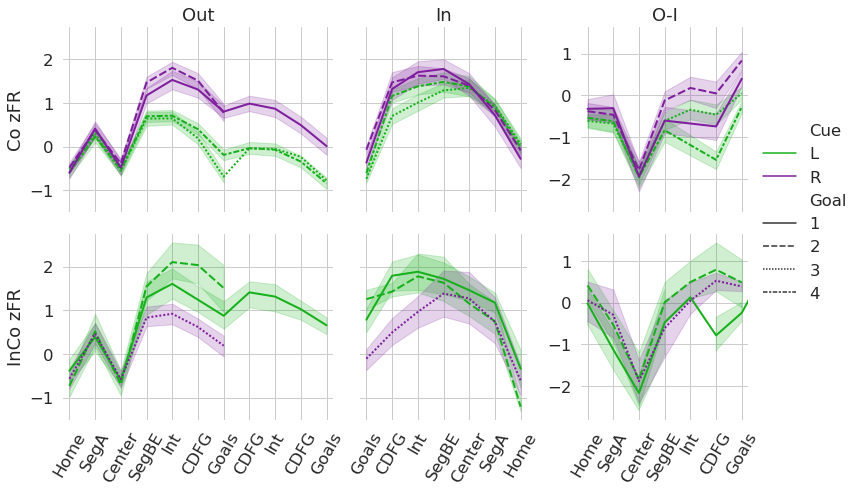

In [3434]:
cell = 10

cellDat = TrialMatInfo.copy()
cellDat['zFR'] = Data[cellCols[cell]]

sns.set()
sns.set(style="whitegrid",context='notebook',font_scale=1.5,rc={ 
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})

pal = sns.xkcd_palette(['green','purple'])

f,ax = plt.subplots(2,3, figsize=(15,6))
w = 0.25
h = 0.43
ratio = 6.5/10.5 
hsp = 0.05
vsp = 0.05
W = [w,w*ratio,w*ratio]
yPos = [vsp,2*vsp+h]
xPos = [hsp,1.5*hsp+W[0],2.5*hsp+W[1]+W[0]]
xlims = [[-0.25,10.25],[3.75,10.25],[-0.25,6.25]]
for i in [0,1]:
    for j in np.arange(3):
        ax[i][j].set_position([xPos[j],yPos[i],W[j],h])
        ax[i][j].set_xlim(xlims[j])

xPosLabels = {}
xPosLabels[0] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals','CDFG','Int','CDFG','Goals'] 
xPosLabels[2] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals']
xPosLabels[1] = xPosLabels[2][::-1]

plotAll = False
alpha=0.15
mlw = 1
with sns.color_palette(pal):
    coSets = ['InCo','Co']
    for i in [0,1]:
        if i==0:
            leg=False
        else:
            leg='brief'
        
        if plotAll:
            subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
            ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                     ax=ax[i][0],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
            ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Desc',estimator=None,units='trID',data=cellDat[subset],
                    ax=ax[i][0],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])
            
            subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
            ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                     ax=ax[i][1],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
            ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                    ax=ax[i][1],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])
           
            subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])  
            ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                        ax=ax[i][2],legend=leg,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
            ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                         ax=ax[i][2],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

        else:
            subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
            ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                  ax=ax[i][0],lw=2,legend=False,hue_order=['L','R'],style_order=['1','2','3','4'])
            subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
            ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                 ax=ax[i][1],lw=2,legend=False,hue_order=['L','R'],style_order=['1','2','3','4'])
            subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
            ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                 ax=ax[i][2],legend=leg,lw=2,hue_order=['L','R'],style_order=['1','2','3','4'])
            
        ax[i][1].set_xticks(np.arange(4,nMaxPos))
        ax[i][0].set_xticks(np.arange(nMaxPos)) 
        ax[i][2].set_xticks(np.arange(nMinPos))
        
        for j in np.arange(3):
            ax[i][j].set_xlabel('')
            ax[i][j].set_ylabel('')
            ax[i][j].tick_params(axis='x', rotation=60)
            
        ax[i][0].set_ylabel('{} zFR'.format(coSets[i]))
        ax[i][1].set_yticklabels('') 
        
        if i==0:
            for j in np.arange(3):
                ax[i][j].set_xticklabels(xPosLabels[j]) 
        else:
            ax[i][0].set_title('Out')
            ax[i][1].set_title('In')
            ax[i][2].set_title('O-I')
            for j in np.arange(3):
                ax[i][j].set_xticklabels('')
    l =ax[1][2].get_legend()
    plt.legend(bbox_to_anchor=(1.05, 0), loc=6, borderaxespad=0.,frameon=False)
    l.set_frame_on(False)

    # out/in limits
    lims = np.zeros((4,2))
    cnt =0
    for i in [0,1]:
        for j in [0,1]:
            lims[cnt]=np.array(ax[i][j].get_ylim())
            cnt+=1
    minY = np.floor(np.min(lims[:,0])*20)/20
    maxY = np.ceil(np.max(lims[:,1]*20))/20
    for i in [0,1]:
        for j in [0,1]:
            ax[i][j].set_ylim([minY,maxY])
    
    # o-i limits
    lims = np.zeros((2,2))
    cnt =0
    for i in [0,1]:
        lims[cnt]=np.array(ax[i][2].get_ylim())
        cnt+=1
    minY = np.floor(np.min(lims[:,0])*20)/20
    maxY = np.ceil(np.max(lims[:,1]*20))/20
    for i in [0,1]:
        ax[i][2].set_ylim([minY,maxY])
    
        

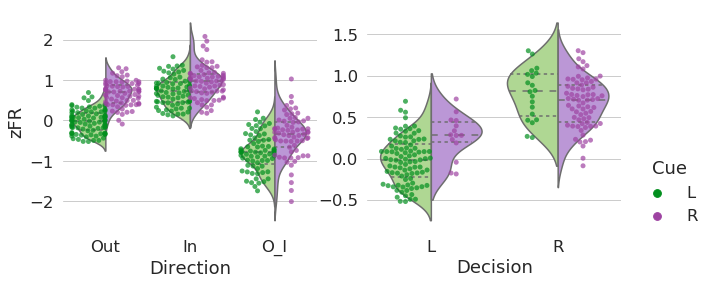

In [2997]:
f,ax = plt.subplots(1,2, figsize=(10,4))

sns.set(style="whitegrid",font_scale=1.5,rc={ 
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})

pal = sns.xkcd_palette(['spring green','light purple'])

subset = cellDat['Co']=='Co'
dat =[]
dat = cellDat[subset].groupby(['trID','IO','Cue','Desc']).mean()
dat = dat.reset_index()
with sns.color_palette(pal):
    ax[0]=sns.violinplot(y='zFR',x='IO',hue='Desc',data=dat,split=True, ax=ax[0],
                      scale='count',inner='quartile',hue_order=['L','R'],saturation=0.5,order=['Out','In','O_I'])
pal = sns.xkcd_palette(['emerald green','medium purple'])
with sns.color_palette(pal):
    ax[0]=sns.swarmplot(y='zFR',x='IO',hue='Desc',data=dat,dodge=True,hue_order=['L','R'],alpha=0.7,ax=ax[0],
                     edgecolor='gray',order=['Out','In','O_I'])
l=ax[0].get_legend()
l.set_visible(False)
ax[0].set_xlabel('Direction')

pal = sns.xkcd_palette(['spring green','light purple'])
subset= cellDat['IO']=='Out'
dat = cellDat[subset].groupby(['trID','Cue','Co','Desc']).mean()
dat = dat.reset_index()

with sns.color_palette(pal):
    ax[1]=sns.violinplot(y='zFR',x='Desc',hue='Cue',data=dat,split=True,scale='width',ax=ax[1],
                      inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.5)
pal = sns.xkcd_palette(['emerald green','medium purple'])
with sns.color_palette(pal):
    ax[1]=sns.swarmplot(y='zFR',x='Desc',hue='Cue',data=dat,dodge=True,order=['L','R'],ax=ax[1],
                        hue_order=['L','R'],alpha=0.7,edgecolor='gray')
ax[1].set_xlabel('Decision')
ax[1].set_ylabel('')
l=ax[1].get_legend()
handles, labels = ax[1].get_legend_handles_labels()
l.set_visible(False)
plt.legend(handles[2:],labels[2:],bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cue')


In [2999]:
cell = 10

cellDat = TrialMatInfo.copy()
cellDat['zFR'] = Data[cellCols[cell]]

subset = (cellDat['Valid']) & ~(cellDat['IO']=='O_I')
dat = cellDat[subset] 
dat = dat.reset_index()
#dat['Pos'] = dat['Pos'].astype('category')
md = smf.mixedlm("zFR ~ Loc*IO+Co+Cue+Desc", data=dat,groups=dat["trID"])
#md = smf.mixedlm("zFR ~ Loc*IO", data=dat,groups=dat["trID"])
#md = smf.mixedlm("zFR ~ IO", data=dat,groups=dat["trID"])

mdf = md.fit()
dat['Fit'] = mdf.fittedvalues
dat['Res'] = mdf.resid
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(dat['Fit'],dat['zFR'])**2)[0,1]))
print(mdf.wald_test_terms())


md = smf.mixedlm("Res ~ Cue+Desc+Co", data=dat,groups=dat["trID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,dat['Res'])**2)[0,1]))
print(mdf.wald_test_terms())


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    zFR       
No. Observations:    2879       Method:                REML      
No. Groups:          200        Scale:                 0.2588    
Min. group size:     7          Likelihood:            -2304.1999
Max. group size:     22         Converged:             Yes       
Mean group size:     14.4                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.373    0.048  28.428 0.000  1.278  1.467
Loc[T.G1]             -1.482    0.097 -15.231 0.000 -1.672 -1.291
Loc[T.G2]             -1.269    0.084 -15.135 0.000 -1.433 -1.104
Loc[T.G3]             -1.967    0.084 -23.487 0.000 -2.131 -1.803
Loc[T.G4]             -1.908    0.093 -20.515 0.000 -2.091 -1.726
Loc[T.Home]           -1

/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


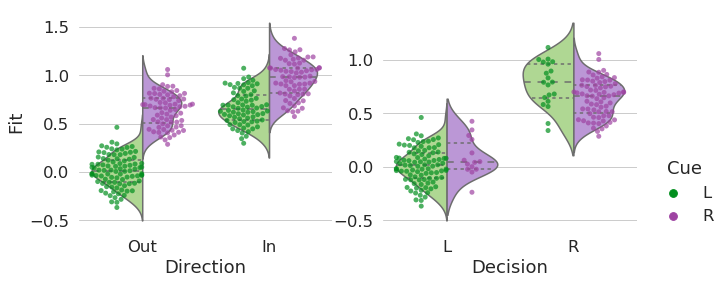

In [3000]:
f,ax = plt.subplots(1,2, figsize=(10,4))

sns.set(style="whitegrid",font_scale=1.5,rc={ 
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})

pal = sns.xkcd_palette(['spring green','light purple'])
y = 'Fit'
subset = dat['Co']=='Co'
dat2 =[]
dat2 = dat[subset].groupby(['trID','IO','Cue','Desc']).mean()
dat2 = dat2.reset_index()
with sns.color_palette(pal):
    ax[0]=sns.violinplot(y=y,x='IO',hue='Desc',data=dat2,split=True, ax=ax[0],
                      scale='count',inner='quartile',hue_order=['L','R'],saturation=0.5,order=['Out','In'])
pal = sns.xkcd_palette(['emerald green','medium purple'])
with sns.color_palette(pal):
    ax[0]=sns.swarmplot(y=y,x='IO',hue='Desc',data=dat2,dodge=True,hue_order=['L','R'],alpha=0.7,ax=ax[0],
                     edgecolor='gray',order=['Out','In'])
l=ax[0].get_legend()
l.set_visible(False)
ax[0].set_xlabel('Direction')

pal = sns.xkcd_palette(['spring green','light purple'])
subset= dat['IO']=='Out'
dat2 =[]
dat2 = dat[subset].groupby(['trID','Cue','Co','Desc']).mean()
dat2 = dat2.reset_index()

with sns.color_palette(pal):
    ax[1]=sns.violinplot(y=y,x='Desc',hue='Cue',data=dat2,split=True,scale='width',ax=ax[1],
                      inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.5)
pal = sns.xkcd_palette(['emerald green','medium purple'])
with sns.color_palette(pal):
    ax[1]=sns.swarmplot(y=y,x='Desc',hue='Cue',data=dat2,dodge=True,order=['L','R'],ax=ax[1],
                        hue_order=['L','R'],alpha=0.7,edgecolor='gray')
ax[1].set_xlabel('Decision')
ax[1].set_ylabel('')
l=ax[1].get_legend()
handles, labels = ax[1].get_legend_handles_labels()
l.set_visible(False)
plt.legend(handles[2:],labels[2:],bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cue')


In [3396]:
TrialInfo['TrDurs']

array([ 632,  404, 1567, 1234,  630,  520,  400,  655,  568,  571,  478,
        400,  465,  456,  545,  347,  518,  366,  587,  395,  367,  439,
        386,  344,  310,  383,  270,  483,  294,  316,  437,  346,  343,
        292,  359,  474,  440,  416,  506,  449,  413,  340,  294,  463,
        377,  381,  371,  395,  426,  306,  312,  283,  352,  362,  454,
        421,  372,  507,  379,  364,  346,  440,  283,  425,  314,  369,
        330,  437,  404,  470,  364,  466,  318,  458,  407,  565,  353,
        327,  297,  474,  332,  426,  449,  480,  394,  413,  336,  429,
        340,  361,  411,  428,  384,  333,  545,  368,  343,  545,  371,
        397,  469,  608,  506,  330,  507,  428,  359,  353,  328,  384,
        316,  420,  438,  335,  439,  491,  398,  295,  380,  420, 1887,
        476,  473,  338,  423,  549,  420,  486,  275,  507,  417,  394,
        353,  362,  338,  497,  411,  581,  438, 1779,  459,  557,  355,
        350,  356,  334,  366,  365,  332,  334,  4

In [3178]:
cell = 10
cellDat = TrialMatInfo.copy()
cellDat['zFR'] = Data[cellCols[cell]] 

dat = []
dat = cellDat[~(cellDat['IO']=='O_I') & (cellDat['Valid'])].copy()
dat['trID'] = dat['trID'].astype('category')
dat = dat.reset_index()

dat_even = dat[dat['EvenTrial']==True]
dat_odd = dat[dat['EvenTrial']==False]

#md1 = smf.mixedlm("zFR ~ Loc*IO+Cue+Desc+Co", data=dat1,groups=dat1["trID"])
#md_even = sm.OLS.from_formula("zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co+trID", data=dat_even)
md_even = smf.mixedlm("zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co", data=dat_even,groups=dat_even["trID"])
mdf_even = md_even.fit()

print('\nPerformance Train-Even:Test-Odd')
print("Train_aR2 = {0:.3f}".format(aR2(mdf_even,dat_even['zFR'])))
print("Model_AICc = {0:.3f}".format(AICc(mdf_even)))
#print(mdf.wald_test_terms())
pred_odd = mdf_even.predict(dat_odd)
print("Test_R2 = {0:.3f}".format(R2(pred_odd,dat_odd['zFR'])))

print('\nPerformance Train-Odd:Test-Even')
#md2 = smf.mixedlm("zFR ~ Loc*IO+Cue+Desc+Co", data=dat2,groups=dat2["trID"])
#md_odd = sm.OLS.from_formula("zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co+trID", data=dat_odd)
md_odd = smf.mixedlm("zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co", data=dat_odd,groups=dat_odd["trID"])
mdf_odd = md_odd.fit()

print("Train_aR2 = {0:.3f}".format(aR2(mdf_odd,dat_odd['zFR'])))
print("Model_AICc = {0:.3f}".format(AICc(mdf_odd)))
#print(mdf.wald_test_terms())
pred_even = mdf_odd.predict(dat_even)
print("Test_R2 = {0:.3f}".format(R2(pred_even,dat_even['zFR'])))
dat['Pred']=np.zeros(dat.shape[0])
dat.loc[dat['EvenTrial']==True,'Pred']=pred_even
dat.loc[dat['EvenTrial']==False,'Pred']=pred_odd

/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


Performance Train-Even:Test-Odd
Train_aR2 = 0.731
Model_AICc = 2318.444
Test_R2 = 0.630

Performance Train-Odd:Test-Even
Train_aR2 = 0.706
Model_AICc = 2469.850
Test_R2 = 0.663


In [3245]:


cell = 10
R2thr = 0.2

param_set = getParamSet()
nModels = len(param_set)

cellDat = TrialMatInfo.copy()
cellDat['zFR'] = Data[cellCols[cell]] 

dat = []
dat = cellDat[~(cellDat['IO']=='O_I') & (cellDat['Valid'])].copy()
dat['trID'] = dat['trID'].astype('category')
dat = dat.reset_index()

params = ['Loc:IO','Loc','IO','Cue','Desc','Co']
form = getFormula(params)
t1 = time.time()
tR2 = getModel_testR2(form,dat)

if tR2>=R2thr:
    for k,params in param_set.items():
        form = getFormula(params)
        t2 = time.time()
        trainR2[k],trainAIC[k],_ = getModelPerf(form,dat)
        t3 = time.time()
        print('Time to fit model {0} : {1} =  {2:0.3f}s'.format(k,form,t3-t2))
        
print('Fitting Completed for cell {0}, total time = {1:0.3f}s'.format(cell,t3-t1))

    


Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


Performance Train-Even:Test-Odd
Train_aR2 = 0.731
Model_AICc = 2318.444
Test_R2 = 0.630

Performance Train-Odd:Test-Even
Train_aR2 = 0.706
Model_AICc = 2469.850
Test_R2 = 0.663

 Overall test R2: 0.645

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



 Model Performance:
Train_aR2 = 0.718
Model_AICc = 4677.237

Computing mixedlm with formula: zFR ~ Loc

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5960.500
Time to fit model 0 : zFR ~ Loc =  0.519

Computing mixedlm with formula: zFR ~ IO

 Model Performance:
Train_aR2 = 0.205
Model_AICc = 7475.265
Time to fit model 1 : zFR ~ IO =  0.552

Computing mixedlm with formula: zFR ~ Cue

 Model Performance:
Train_aR2 = 0.141
Model_AICc = 7638.327
Time to fit model 2 : zFR ~ Cue =  0.400

Computing mixedlm with formula: zFR ~ Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.136
Model_AICc = 7549.645
Time to fit model 3 : zFR ~ Desc =  17.137

Computing mixedlm with formula: zFR ~ Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.155
Model_AICc = 7678.930
Time to fit model 4 : zFR ~ Co =  15.730

Computing mixedlm with formula: zFR ~ Loc+IO


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.601
Model_AICc = 5506.354
Time to fit model 5 : zFR ~ Loc+IO =  19.379

Computing mixedlm with formula: zFR ~ Loc+Cue

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5966.912
Time to fit model 6 : zFR ~ Loc+Cue =  0.626

Computing mixedlm with formula: zFR ~ Loc+Desc

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5965.937
Time to fit model 7 : zFR ~ Loc+Desc =  0.609

Computing mixedlm with formula: zFR ~ Loc+Co

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5961.999
Time to fit model 8 : zFR ~ Loc+Co =  0.588

Computing mixedlm with formula: zFR ~ IO+Cue

 Model Performance:
Train_aR2 = 0.197
Model_AICc = 7441.451
Time to fit model 9 : zFR ~ IO+Cue =  0.506

Computing mixedlm with formula: zFR ~ IO+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.197
Model_AICc = 7344.380
Time to fit model 10 : zFR ~ IO+Desc =  17.615

Computing mixedlm with formula: zFR ~ IO+Co

 Model Performance:
Train_aR2 = 0.203
Model_AICc = 7471.715
Time to fit model 11 : zFR ~ IO+Co =  0.599

Computing mixedlm with formula: zFR ~ Cue+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.135
Model_AICc = 7554.177
Time to fit model 12 : zFR ~ Cue+Desc =  17.160

Computing mixedlm with formula: zFR ~ Cue+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.101
Model_AICc = 7646.850
Time to fit model 13 : zFR ~ Cue+Co =  17.172

Computing mixedlm with formula: zFR ~ Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.136
Model_AICc = 7550.675
Time to fit model 14 : zFR ~ Desc+Co =  17.609

Computing mixedlm with formula: zFR ~ Loc+IO+Cue


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.603
Model_AICc = 5512.464
Time to fit model 15 : zFR ~ Loc+IO+Cue =  21.274

Computing mixedlm with formula: zFR ~ Loc+IO+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.605
Model_AICc = 5514.496
Time to fit model 16 : zFR ~ Loc+IO+Desc =  20.696

Computing mixedlm with formula: zFR ~ Loc+IO+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.599
Model_AICc = 5506.712
Time to fit model 17 : zFR ~ Loc+IO+Co =  23.762

Computing mixedlm with formula: zFR ~ Loc+Cue+Desc

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5972.130
Time to fit model 18 : zFR ~ Loc+Cue+Desc =  0.667

Computing mixedlm with formula: zFR ~ Loc+Cue+Co

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5968.297
Time to fit model 19 : zFR ~ Loc+Cue+Co =  0.730

Computing mixedlm with formula: zFR ~ Loc+Desc+Co

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5967.698
Time to fit model 20 : zFR ~ Loc+Desc+Co =  0.588

Computing mixedlm with formula: zFR ~ IO+Cue+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.196
Model_AICc = 7347.603
Time to fit model 21 : zFR ~ IO+Cue+Desc =  18.279

Computing mixedlm with formula: zFR ~ IO+Cue+Co

 Model Performance:
Train_aR2 = 0.195
Model_AICc = 7435.126
Time to fit model 22 : zFR ~ IO+Cue+Co =  0.510

Computing mixedlm with formula: zFR ~ IO+Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.197
Model_AICc = 7344.758
Time to fit model 23 : zFR ~ IO+Desc+Co =  18.688

Computing mixedlm with formula: zFR ~ Cue+Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.134
Model_AICc = 7555.262
Time to fit model 24 : zFR ~ Cue+Desc+Co =  18.245

Computing mixedlm with formula: zFR ~ Loc+IO+Cue+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.605
Model_AICc = 5520.593
Time to fit model 25 : zFR ~ Loc+IO+Cue+Desc =  21.964

Computing mixedlm with formula: zFR ~ Loc+IO+Cue+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.603
Model_AICc = 5512.534
Time to fit model 26 : zFR ~ Loc+IO+Cue+Co =  17.600

Computing mixedlm with formula: zFR ~ Loc+IO+Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.604
Model_AICc = 5514.008
Time to fit model 27 : zFR ~ Loc+IO+Desc+Co =  22.158

Computing mixedlm with formula: zFR ~ Loc+Cue+Desc+Co

 Model Performance:
Train_aR2 = 0.529
Model_AICc = 5973.884
Time to fit model 28 : zFR ~ Loc+Cue+Desc+Co =  0.670

Computing mixedlm with formula: zFR ~ IO+Cue+Desc+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.196
Model_AICc = 7348.444
Time to fit model 29 : zFR ~ IO+Cue+Desc+Co =  17.719

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO

 Model Performance:
Train_aR2 = 0.718
Model_AICc = 4664.871
Time to fit model 30 : zFR ~ Loc:IO+Loc+IO =  0.750

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue

 Model Performance:
Train_aR2 = 0.718
Model_AICc = 4670.806
Time to fit model 31 : zFR ~ Loc:IO+Loc+IO+Cue =  0.812

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



 Model Performance:
Train_aR2 = 0.718
Model_AICc = 4671.367
Time to fit model 32 : zFR ~ Loc:IO+Loc+IO+Desc =  2.114

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Co


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.719
Model_AICc = 4666.743
Time to fit model 33 : zFR ~ Loc:IO+Loc+IO+Co =  23.232

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc


/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alexg8/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed


 Model Performance:
Train_aR2 = 0.720
Model_AICc = 4679.723
Time to fit model 34 : zFR ~ Loc:IO+Loc+IO+Cue+Desc =  23.124

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Co

 Model Performance:
Train_aR2 = 0.718
Model_AICc = 4671.339
Time to fit model 35 : zFR ~ Loc:IO+Loc+IO+Cue+Co =  0.760

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Desc+Co

 Model Performance:
Train_aR2 = 0.718
Model_AICc = 4671.695
Time to fit model 36 : zFR ~ Loc:IO+Loc+IO+Desc+Co =  0.792


TypeError: format() argument 2 must be str, not float

In [3424]:
from joblib import Parallel, delayed
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


all_params = ['Loc:IO','Loc','IO','Cue','Desc','Co']
param_set = getParamSet()
nModels = len(param_set)
R2thr = 0.2
    
nTr =len(TrialInfo['All']['Trials'])
cellColIDs =  [i for i,item in enumerate(Data.columns.values) if 'cell' in item]
nCells = len(cellColIDs)
muaColIDs =  [i for i,item in enumerate(Data.columns.values) if 'mua' in item]
nMua = len(musColIDs)
nTotalUnits = nCells+nMua
nUnits = {'cell':nCells,'mua':nMua}

cellCols = Data.columns[cellColIDs]
muaCols = Data.columns[muaColIDs]
unitCols = {'cell':cellCols,'mua':muaCols}

perfCols = ['FullMod_tR2','modelNum','trainR2','AICc','testR2'] 
Cols = ['ut']+perfCols+ all_params
nCols = len(Cols)
LM_Dat = pd.DataFrame(np.full((nTotalUnits,nCols),np.nan),columns=Cols)
LM_Dat.loc[:,'ut'] = ['cell']*nCells+['mua']*nMua

datSubset = ~(TrialMatInfo['IO']=='O_I') & (TrialMatInfo['Valid'])
dat = []
dat = TrialMatInfo[datSubset].copy()
dat['trID'] = dat['trID'].astype('category')
dat = dat.reset_index()
N = dat.shape[0]
dat['zFR'] = np.zeros(N)

t0 = time.time()
with Parallel(n_jobs=16) as parallel:
    cnt=0
    for ut in ['cell','mua']:
        for cell in np.arange(nUnits[ut]): 
            print('\n\nAnalyzing {} {}'.format(ut,cell))

            dat.loc[:,'zFR'] = Data.loc[datSubset,unitCols[ut][cell]].values    

            t1 = time.time()
            tR2 = getModel_testR2(dat,params=all_params)
            t2 = time.time()
            LM_Dat.loc[cnt,'FullMod_tR2'] = tR2

            print('Full Model Test Set Fit completed. Time = {}'.format(t2-t1))
            if tR2>=R2thr:
                print('Full Model passed the threshold, looking for optimal submodel.')
                r = parallel(delayed(getModelPerf)(dat,params=params) for params in param_set.values())
                trainR2,trainAICc,_ = zip(*r)

                t3 = time.time()
                print('\nFitting Completed for {0} {1}, total time = {2:0.3f}s'.format(ut,cell,t3-t1))
                selMod = np.argmin(trainAICc)

                selMod_tR2 = getModel_testR2(dat,params=param_set[selMod])
                print('Selected Model = {}, AICc = {}, testR2 = {} '.format(selMod,trainAICc[selMod],selMod_tR2))

                LM_Dat.loc[cnt,'modelNum']=selMod
                LM_Dat.loc[cnt,'trainR2']=trainR2[selMod]
                LM_Dat.loc[cnt,'AICc'] = trainAICc[selMod]
                LM_Dat.loc[cnt,'testR2'] = selMod_tR2

                temp = r[selMod][2].wald_test_terms()
                LM_Dat.loc[cnt,param_set[selMod]] = np.sqrt(temp.summary_frame()['chi2'][param_set[selMod]])
            cnt+=1
print('Model Fitting completed. Time = {}s'.format(time.time()-t0))


Analyzing cell 0

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co

Overall test R2: 0.010
Full Model Test Set Fit completed. Time = 1.9928991794586182

Analyzing cell 1

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co

Overall test R2: 0.084
Full Model Test Set Fit completed. Time = 0.7516374588012695

Analyzing cell 2

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co

Overall test R2: 0.208
Full Model Test Set Fit completed. Time = 0.7196385860443115
Full Model passed the threshold, looking for optimal submodel.


Fitting Completed for cell 2, total time = 19.928s

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Co

Overall test R2: 0.209
Selected Model = 34, AICc = 6689.746441247439, testR2 = 0.20896430342682012 

Analyzing cell 3

Computing mixedlm with formula: zFR ~ Loc:IO+Loc+IO+Cue+Desc+Co

Overall test R2: 0.578
Full Model Test Set Fit completed. Time = 0.6880843639373779
Full Model passed the threshold, looking for optimal su

In [3458]:
LM_Dat

,ut,FullMod_tR2,modelNum,trainR2,AICc,testR2,Loc:IO,Loc,IO,Cue,Desc,Co
0,cell,0.010051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cell,0.084407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cell,0.207722,34.0,0.406912,6689.746441,0.208964,11.855015,14.993178,5.350268,NaN,NaN,2.440998
3,cell,0.578138,32.0,0.647653,5927.329701,0.577455,36.247952,41.655121,18.938309,2.892164,NaN,NaN
4,cell,0.005673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,cell,0.448013,31.0,0.554971,5765.774490,0.448223,25.371539,39.405906,19.417544,NaN,NaN,NaN
6,cell,0.498452,31.0,0.620789,5618.716020,0.496870,30.129192,42.000540,25.229875,NaN,NaN,NaN
7,cell,0.137297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,cell,0.411694,34.0,0.530198,5944.003239,0.411120,24.822153,36.274452,19.262850,NaN,NaN,4.733961
9,cell,0.170676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3241]:
param_set

{0: ['Loc'],
 1: ['IO'],
 2: ['Cue'],
 3: ['Desc'],
 4: ['Co'],
 5: ['Loc', 'IO'],
 6: ['Loc', 'Cue'],
 7: ['Loc', 'Desc'],
 8: ['Loc', 'Co'],
 9: ['IO', 'Cue'],
 10: ['IO', 'Desc'],
 11: ['IO', 'Co'],
 12: ['Cue', 'Desc'],
 13: ['Cue', 'Co'],
 14: ['Desc', 'Co'],
 15: ['Loc', 'IO', 'Cue'],
 16: ['Loc', 'IO', 'Desc'],
 17: ['Loc', 'IO', 'Co'],
 18: ['Loc', 'Cue', 'Desc'],
 19: ['Loc', 'Cue', 'Co'],
 20: ['Loc', 'Desc', 'Co'],
 21: ['IO', 'Cue', 'Desc'],
 22: ['IO', 'Cue', 'Co'],
 23: ['IO', 'Desc', 'Co'],
 24: ['Cue', 'Desc', 'Co'],
 25: ['Loc', 'IO', 'Cue', 'Desc'],
 26: ['Loc', 'IO', 'Cue', 'Co'],
 27: ['Loc', 'IO', 'Desc', 'Co'],
 28: ['Loc', 'Cue', 'Desc', 'Co'],
 29: ['IO', 'Cue', 'Desc', 'Co'],
 30: ['Loc:IO', 'Loc', 'IO'],
 31: ['Loc:IO', 'Loc', 'IO', 'Cue'],
 32: ['Loc:IO', 'Loc', 'IO', 'Desc'],
 33: ['Loc:IO', 'Loc', 'IO', 'Co'],
 34: ['Loc:IO', 'Loc', 'IO', 'Cue', 'Desc'],
 35: ['Loc:IO', 'Loc', 'IO', 'Cue', 'Co'],
 36: ['Loc:IO', 'Loc', 'IO', 'Desc', 'Co']}

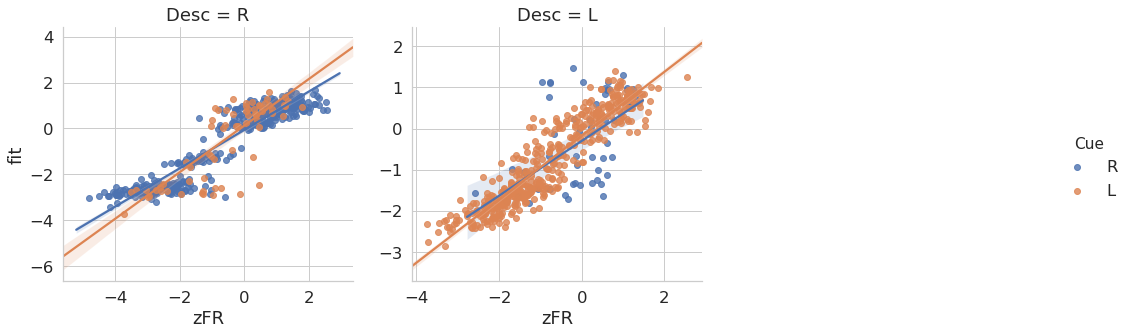

In [1953]:
sns.lmplot(x='zFR',y='fit',hue='Cue',col='Desc',data=dat2,col_wrap=3,sharex=False, sharey=False, robust=True)

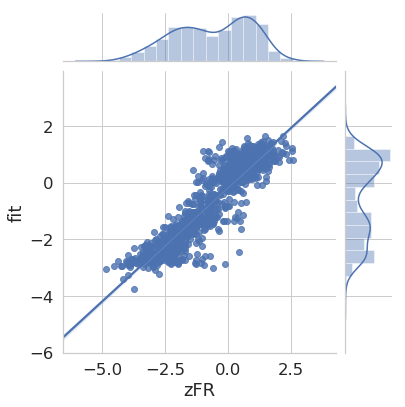

In [1961]:
sns.set_style("whitegrid")
sns.jointplot(dat2['zFR'],dat2['fit'],kind='reg')